In [1]:
import tensorflow as tf
import numpy as np
from numpy.lib.stride_tricks import as_strided
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import Adam
import cv2
from utils.video_decoding import VideoDecoder
import time

C:\Users\Alibaba\AppData\Local\Programs\Python\Python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
video_data = VideoDecoder("data_gather/cctv_data/output_12_31_11.mp4")

In [3]:
previous_frame = video_data.current_frame
previous_frame = cv2.cvtColor(previous_frame, cv2.COLOR_BGR2GRAY)

In [4]:
video_data.next_frame()

In [5]:
current_frame = video_data.current_frame
current_frame = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)

In [6]:
current_frame

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 1,  1,  4, ...,  0,  0,  0],
       [ 2,  1,  0, ...,  0,  0,  0],
       ...,
       [23, 24, 24, ..., 45, 36, 38],
       [24, 25, 25, ..., 51, 50, 52],
       [24, 25, 25, ..., 50, 50, 53]], dtype=uint8)

In [554]:
diff = np.abs(current_frame - previous_frame)

In [555]:
def pool2d(A, kernel_size, stride, padding=0, pool_mode='max'):
    """
     2D Pooling

     Parameters:
         A: input 2D array
         kernel_size: int, the size of the window over which we take pool
         stride: int, the stride of the window
         padding: int, implicit zero paddings on both sides of the input
         pool_mode: string, 'max' or 'avg'
     """
    # Padding
    A = np.pad(A, padding, mode='constant')

    # Window view of A
    output_shape = ((A.shape[0] - kernel_size) // stride + 1,
                    (A.shape[1] - kernel_size) // stride + 1)

    shape_w = (output_shape[0], output_shape[1], kernel_size, kernel_size)
    strides_w = (stride*A.strides[0], stride*A.strides[1], A.strides[0], A.strides[1])

    A_w = as_strided(A, shape_w, strides_w)

    # Return the result of pooling
    if pool_mode == 'max':
        return A_w.max(axis=(2, 3))
    elif pool_mode == 'avg':
        return A_w.mean(axis=(2, 3))

In [556]:
diff_pooled = pool2d(diff, 30, 30, padding=0, pool_mode='avg')

In [557]:
func = lambda x: True if x > 200 else False
func = np.vectorize(func)

diff_pooled = func(diff_pooled)

In [558]:
diff_pooled

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False

In [559]:
new_frame = np.zeros((diff.shape[0], diff.shape[1]))

In [560]:
new_frame

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [561]:
new_frame[diff > 20] = 255

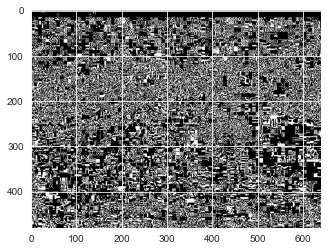

In [562]:
plt.imshow(new_frame, cmap='gray')

## How to label data for images for CNN to learn from
Estimate the average size of car in pixels --> maybe around 25x25 pixels
Then we take the difference between two images and check if there are any areas in 25x25 with changing pixels aka moving object size of 25x25 and label that center of that are as a center location for a car

In [563]:
new_frame.shape

(480, 640)

In [564]:
for i in range(int(new_frame.shape[0] / 30)):
    for j in range(int(new_frame.shape[1] / 30)):
        if np.sum(new_frame[i*30:(i+1)*30, j*30:(j+1)*30]) < 75_000:
            new_frame[i*30:(i+1)*30, j*30:(j+1)*30] = 0

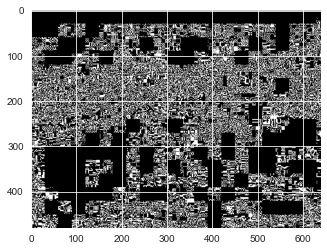

In [565]:
plt.imshow(new_frame, cmap='gray')

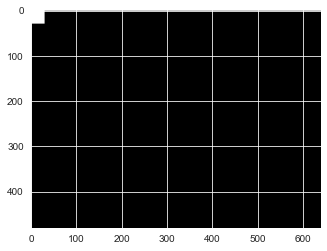

In [566]:
test_r = np.zeros((480, 640))
test_r[0:30, 0:30] = 255
plt.imshow(test_r, cmap='gray')

(12, 160, 160)


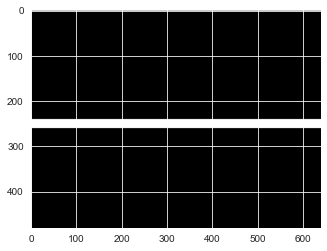

In [567]:
test_r = np.zeros((480, 640))
test_r = test_r.reshape(-1, 160, 160)
print(test_r.shape)
test_r[6, 0:80] = 255
test_r = test_r.reshape(480, 640)
plt.imshow(test_r, cmap='gray')

In [568]:
for x in range(200):
    try:
        test_r.reshape(-1, x, x)
        print(x)
    except:
        pass

1
2
4
5
8
10
16
20
32
40
64
80
160
